---
# Perkenalan

Nama     : I Made Dhanan Pradipta <br>
Batch    : 10
Judul    : Sentiment Analysis menggunakan data Twitter, berdasarkan makna kata  <br>
______________________________

Objectif : Objectif yang diharapkan dalam pembuatan model adalah untuk mengukur tingkat keakuratan sentiment pada twitter berdasarkan makna dari tweet yang dituliskan di twitter
______________________________

Dataset  : Data didapatkan dengan cara scraping pada sosial media twitter. karena keterbatasan access maka waktu yang didapatkan hanya selama 7 hari kebelakang dan topik pembicaraan dicari menggunakan hastag #MondayMotivation,
dimana hashtag ini menjadi trending topic worldwide pada hari Senin 30/05/2022

---
# Import Library

library yang digunakan untuk scraping adalah _tweepy_
untuk pemodelan menggunakan tensorflow _LSTM_ dan _GRU_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
nltk.download('punkt')
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

from itertools import chain
import collections
from wordcloud import WordCloud, STOPWORDS
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


ModuleNotFoundError: No module named 'wordcloud'

---
# Data Loading

setelah scraping data menggunakan notebook **searching_tweet.ipynb** <br>
dataset dicollect menggunakan type json <br>
data dibagi menjadi 2 file, utk membedakan antara sentiment negative dan positive

Sentiment Positif didapatkan dengan cara collect data dengan makna positf yaitu:
happy 

*   exciting 
*   excited
*   favorite
*   amazing
*   lovely
*   incredible


Sedangkan, untuk sentiment negatif, digambarkan dengan kata :


*   horrible
*   worst
*   sucks
*   bad
*   disappointing








In [ ]:
pos = pd.read_json('positive_tweet.json')
neg = pd.read_json('negative_tweet.json')

frame = [pos, neg]
df = pd.concat(frame)

In [ ]:
df.head()

,text,sentiment
0,RT @EverdreamValley: 2000 FOLLOWERS! 😍\nLook h...,positive
1,RT @callieokwu: Naira falls across markets - T...,positive
2,RT @rajput_sanjeeta: #Mondaymotivation\nWhen L...,positive
3,RT @ANSHIKA96239490: Always help needy ones wi...,positive
4,Sri Lanka to propose for transfer of Asia Cup ...,positive


In [ ]:
df.shape

(791, 2)

Insight ;


1.   text berjumlah 791
2.   sentiment positif : 500
3.   sentiment negatif : 291



# Exploratory Data Analysis



In [ ]:
df.groupby('sentiment').size().reset_index(name='counts')

,sentiment,counts
0,negative,291
1,positive,500


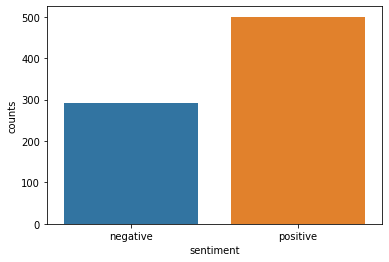

In [ ]:
group = df.groupby('sentiment').size().reset_index(name='counts')
sns.barplot(x='sentiment', y='counts', data=group)

Insight:


1.   Perbedaan antara sentiment negatif dan positif, dikarenakan pada hari tersebut lebih banyak user yang mengikuti percakapan dengan hashtag #MondayMotivation berkonotasi positif
2.   disini dapat disimpulkan bahwa, dari hashtag kita dapat memprediksi sentiment apa yang orang tweet



# Preprocessing

## Cleaning Data

remove character atau kata yang dirasa tidak terlalu berpengaruh, ini dimaksudkan utk membuat proses permodelan menjadi lebih efisien waktu dan kapasitas yang dibutuhkan

In [ ]:
#drop duplicate
df['text'].drop_duplicates(inplace=True)

In [ ]:
#lowecase text
#remove punctation
#remove hashtag and mention
#remove @
#remove RT
# new_text = []
# def clean_data(data):
#     for text in data:
#         text = re.sub(r'[^\w\s]','',text)
#         new_text.append(text)
#     return new_text

# clean_data(df['text'])
# df['text'] = new_text
df['text'] = df['text'].apply(lambda x: re.compile('\#').sub('', re.compile('RT @').sub('@', x, count=1).strip()))


In [ ]:
df['text'].head()

0    @EverdreamValley: 2000 FOLLOWERS! 😍\nLook how ...
1    @callieokwu: Naira falls across markets - THE ...
2    @rajput_sanjeeta: Mondaymotivation\nWhen Lord ...
3    @ANSHIKA96239490: Always help needy ones with ...
4    Sri Lanka to propose for transfer of Asia Cup ...
Name: text, dtype: object

**@** sengaja tidak saya hapus karena, menerangkan suatu akun, dan pendapat saya itu bisa menjadi pembeda antara tweet percakapan dan nama sebuah account

## Word Tokenizer
Tokenizer digunakan utk memecah dokumen manjadi masing-masing corpus, sehingga dari corpus tersebut dapat dicara maknanya, dan juga kata yang terkait dengan hal itu
Contoh :





happy --> laugh <br>


excited --> courage <br>

dissapointed --> sad <br>
horrible --> annoyed <br>

dan lainya

In [ ]:
df['tokenized_text'] = df['text'].apply(word_tokenize) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


hasil dari tokenize berupa list dari text yang diproses

## Check Frequency

Check Freq merupakan salah satu Exploratory Analysis, dimana kita melihat seberapa banyak kata pada text, hasil dari freq juga dapat dijadikan bahan pertimbangan apakah terdapat character yang tidak perlu digunakan 

In [ ]:
# List of all words
all_words_no_urls = list(chain(*df['tokenized_text']))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

counts_no_urls.most_common(15)

[('@', 1000),
 (':', 865),
 ('.', 546),
 (',', 507),
 ('to', 435),
 ('!', 352),
 ('the', 346),
 ('MondayMotivation', 339),
 ('of', 250),
 ('a', 226),
 ('and', 222),
 ('you', 215),
 ('in', 215),
 ('https', 211),
 ('bad', 186)]

Insight :    
char yang paling banya yaitu **@**, sangat wajar karena data yang discraping merupakan data percakapan sehingga mentions ke user tertentu pasti sangat banyak,
selain itu punctation atau tanda baca dan jg stopword lumayan banyak, sehingga dipertimbangkan utk dihapus

## Stopwords

Stop words merupakan, kata yang tidak terlalu bermakna, atau bisa dibilang kata lain tidak kehilangan katanya bila stopword dihilangkan,
Contoh in english :         
***and, i, you, my, is, the, he/she, etc***

In [ ]:
stop_words = set(stopwords.words('english'))
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item for item in x if item not in stop_words])

df['tokenized_text'].head()

0    [@, EverdreamValley, :, 2000, FOLLOWERS, !, 😍,...
1    [@, callieokwu, :, Naira, falls, across, marke...
2    [@, rajput_sanjeeta, :, Mondaymotivation, When...
3    [@, ANSHIKA96239490, :, Always, help, needy, o...
4    [Sri, Lanka, propose, transfer, Asia, Cup, 202...
Name: tokenized_text, dtype: object

Insight :               
ternyata masih ada punctuation atau tanda baca, yang tidak bermakna apa-apa, sehingga dipertimbangkan utk dihapus 

## WordCloud

Wordcloud, seperti namanya yaitu awan kata, salah satu Exploratory Analysis dimana wordcloud menggambarkan kata-kata yang paling sering bermunculan berdsarkan sentiment

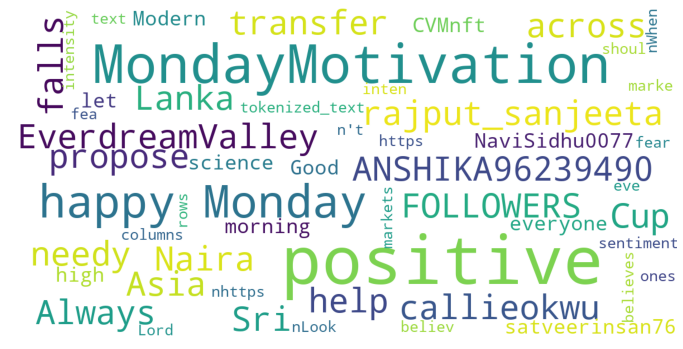

In [ ]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df.loc[df['sentiment'] == 'positive'])

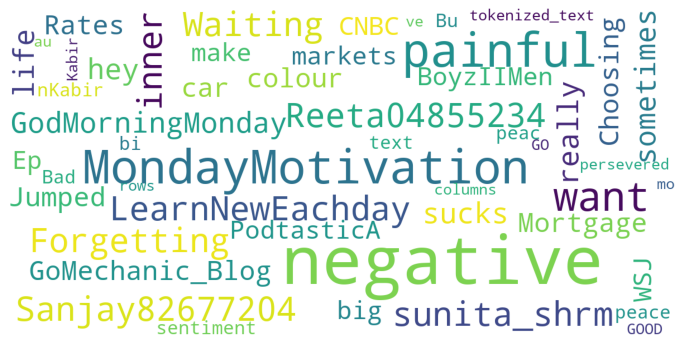

In [ ]:
show_wordcloud(df.loc[df['sentiment'] == 'negative'])

Insight :           
pada sentiment positif, terdapat beberapa kata yang memang kalau secara logika tidak bermakna positif namun kenyataanya memang sering muncul, dan dari sentiment positif kita bisa lihat makna yang memiliki makna postif yaitu <br>
***modern, believ, lord, high, happy, good, morning, eve***

Sedangkan pada sentiment negatif yaitu <br>
***waiting, bad, jumped, sucks, choosing, painful***

## Model Deep Learning

setelah data dirasa sudah cukup bersih, maka kita lanjutkan ketahap pemodelan, yang dimulai dengan split data ke train, val, dan test

In [ ]:
map = {'positive': 1, 'negative': 0}
df['target'] = df['sentiment'].map(map)

In [ ]:
X = df['text']
y = df['target']

In [ ]:
from sklearn.model_selection import train_test_split

#split data into train, test, val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=50, stratify=df.sentiment)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50, stratify=df.sentiment)

In [ ]:
X_train.shape

(711,)

In [ ]:
X_test.shape

(80,)

In [ ]:
X_val.shape

(119,)

In [ ]:
import tensorflow as tf

#pipeline tensorflow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

Train diset ke 90% dari data, val diset ke 15% dari data sedangkan test 10% dari data

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# encode = LabelEncoder()
# encode.fit(y_train)
# y_train_enc = encode.transform(y_train)
# y_val_enc = encode.transform(y_val)
# y_test_enc = encode.transform(y_test)

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# vect = TfidfVectorizer(max_features=2000)
# X_train_vct = vect.fit_transform(X_train)
# X_val_vct = vect.transform(X_val)
# X_test_vct = vect.transform(X_test)


TextVectorization adalah mengubah kata atau kalimat yang sudah kita cleaning sebelumnya kedalam bentuk vektor, yang dimana nantinya dari nilai vektor tsb dicari kemiripan nilai yang dalam kasus kali ini utk mencari sebuah senitment analysis
library yang digunakan yaitu TextVectorization

In [ ]:
max_vocab_length = 3500
max_length = 17

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_length,
                                       input_shape=(1,))

In [ ]:
text_vectorization.adapt(X_train)

berbeda dengan teknik vektorisasi lainya, TextVectorization menggunakan .adapt utk mempelajari dataset

In [ ]:
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_length)

WordEmbeding itu sendiri berarti  kelas teknik di mana kata-kata individual direpresentasikan sebagai vektor bernilai nyata dalam ruang vektor yang telah ditentukan.Setiap kata dipetakan ke satu vektor dan nilai-nilai vektor dipelajari dengan cara yang menyerupai jaringan saraf dalam Artificial Intelligence atau yang sering dikenal dengan kecerdasan buatan, dan karenanya teknik ini sering disamakan dengan bidang pembelajaran yang mendalam.

---
# Model Training
Sequential model menggunakan ***1 embedding layer***, dan juga ***1 hidden layer***, activation yang digunakan adalah ***relu***, optimizer yang digunakan adalah ***adam***

In [ ]:
model = Sequential()
model.add(text_vectorization)
model.add(embedding)
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_hist_1 = model.fit(X_train, 
                         y_train, validation_data = (X_val, y_val), 
                         epochs = 20
                         )

Epoch 1/20
23/23 [==============================] - 1s 22ms/step - loss: 0.6628 - accuracy: 0.7525 - val_loss: 0.6017 - val_accuracy: 0.7899
Epoch 2/20
23/23 [==============================] - 0s 11ms/step - loss: 0.5116 - accuracy: 0.8945 - val_loss: 0.3809 - val_accuracy: 0.9328
Epoch 3/20
23/23 [==============================] - 0s 13ms/step - loss: 0.2738 - accuracy: 0.9648 - val_loss: 0.1879 - val_accuracy: 0.9496
Epoch 4/20
23/23 [==============================] - 0s 14ms/step - loss: 0.1127 - accuracy: 0.9831 - val_loss: 0.1086 - val_accuracy: 0.9580
Epoch 5/20
23/23 [==============================] - 0s 11ms/step - loss: 0.0498 - accuracy: 0.9972 - val_loss: 0.0803 - val_accuracy: 0.9580
Epoch 6/20
23/23 [==============================] - 0s 11ms/step - loss: 0.0259 - accuracy: 1.0000 - val_loss: 0.0691 - val_accuracy: 0.9580
Epoch 7/20
23/23 [==============================] - 0s 13ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0621 - val_accuracy: 0.9580
Epoch 8/20
23

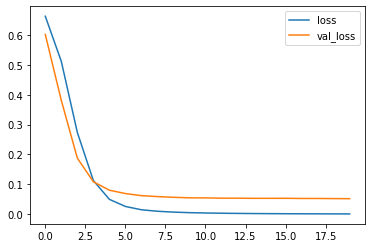

In [ ]:
metrics = pd.DataFrame(model_hist_1.history)
metrics[['loss', 'val_loss']].plot()

In [ ]:
p_pred = model.predict(X_test)
p_pred = p_pred.flatten()

# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)

cm = confusion_matrix(y_test, y_pred)

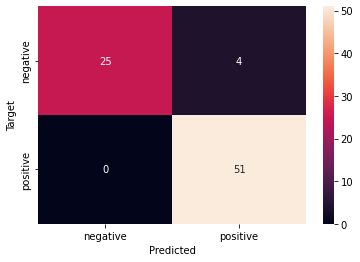

In [ ]:
def plot_cm(cm):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sns.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

plot_cm(cm)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93        29
           1       0.93      1.00      0.96        51

    accuracy                           0.95        80
   macro avg       0.96      0.93      0.94        80
weighted avg       0.95      0.95      0.95        80



Insight :    
1. dari perhitungan metrics didapatkan bahwa data training dan test cukup baik dengan acurasi skore 95%
2. dari confusion matrixnya dapat dilihat bahwa, pembelajaran cukup baik baik sentiment negatif maupun positif
dengan 51 model bisa belajar pada sentimen positif dan hanya 4 buah yang dipelajari negatif atau _False Positif_
sedangkan sentiment negatif, didapatkan bahwa model dapat belajar dengan sangat baik, dan tidak terdapat kesalahan target
3. Frafik loss-val_loss tidak terdapat explode atau vanish, sehingga model bisa dikatakan cukup baik


## LSTM

LSTM hadir untuk melengkapi kekurangan RNN yang tidak dapat memprediksi kata berdasarkan informasi lampau yang disimpan dalam jangka waktu lama. 

Dengan demikian, LSTM mampu mengingat kumpulan informasi yang telah disimpan dalam jangka waktu panjang, sekaligus menghapus informasi yang tidak lagi relevan. LSTM lebih efisien dalam memproses, memprediksi, sekaligus mengklasifikasikan data berdasarkan urutan waktu tertentu

In [ ]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(text_vectorization)
model.add(embedding)
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
model_hist_2 = model.fit(X_train, 
                         y_train, validation_data = (X_val, y_val), 
                         epochs = 20
                         )

Epoch 1/20
23/23 [==============================] - 4s 59ms/step - loss: 0.4285 - accuracy: 0.9550 - val_loss: 0.1163 - val_accuracy: 0.9580
Epoch 2/20
23/23 [==============================] - 1s 27ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.2498 - val_accuracy: 0.9580
Epoch 3/20
23/23 [==============================] - 1s 28ms/step - loss: 0.0359 - accuracy: 0.9930 - val_loss: 0.2013 - val_accuracy: 0.9580
Epoch 4/20
23/23 [==============================] - 1s 26ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0951 - val_accuracy: 0.9748
Epoch 5/20
23/23 [==============================] - 1s 28ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1056 - val_accuracy: 0.9664
Epoch 6/20
23/23 [==============================] - 1s 28ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1109 - val_accuracy: 0.9664
Epoch 7/20
23/23 [==============================] - 1s 25ms/step - loss: 7.5982e-04 - accuracy: 1.0000 - val_loss: 0.1166 - val_accuracy: 0.9664
Epoch 8/2

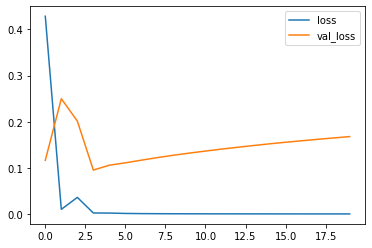

In [ ]:
metrics = pd.DataFrame(model_hist_2.history)
metrics[['loss', 'val_loss']].plot()

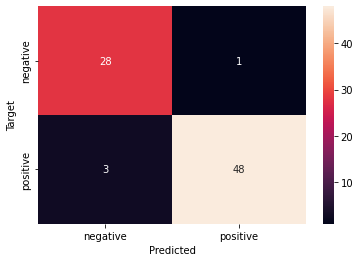

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
p_pred = model.predict(X_test)
p_pred = p_pred.flatten()

# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)

cm_lstm = confusion_matrix(y_test, y_pred)
def plot_cm(cm):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sns.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

plot_cm(cm_lstm)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        29
           1       0.98      0.94      0.96        51

    accuracy                           0.95        80
   macro avg       0.94      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



Insight ;             
1. dengan layer yang sama seperti NN sebelumnya tidak terdapat perubahan secara siginifakn terhadap model, ini bisa diakibatkan karena model yang memiliki data tidak terlalu banyak sehingga hasil yang didapat tidak terlalu jauh
2. peningkatan terjadi pada pembelajaran sentiment postif yang dimana hanya terjadi kesalahan 1 kali pada _False Positif_

## GRU
sebenarnya GRU adalah penyederhanaan dari LSTM dimana hanya ada 1 output yang digunakan, Di dalam GRU, komponen pengatur alur informasi tersebut disebut sebagai gate dan GRU mempunyai 2 gate, yaitu reset gate dan update gate. Bila kita ingin membuat keputusan untuk makan seperti analogi diatas, reset gate pada GRU akan menentukan bagaimana untuk menggabungkan input baru dengan informasi masa lalu, dan update gate, akan menentukan berapa banyak informasi masa lalu yang harus tetap disimpan.

In [ ]:
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(text_vectorization)
model.add(embedding)
model.add(GRU(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_hist_3 = model.fit(X_train, 
                         y_train, validation_data = (X_val, y_val), 
                         epochs = 20
                         )

Epoch 1/20
23/23 [==============================] - 4s 55ms/step - loss: 0.4430 - accuracy: 0.9128 - val_loss: 0.1563 - val_accuracy: 0.9496
Epoch 2/20
23/23 [==============================] - 1s 26ms/step - loss: 0.0215 - accuracy: 0.9958 - val_loss: 0.0821 - val_accuracy: 0.9664
Epoch 3/20
23/23 [==============================] - 1s 26ms/step - loss: 1.7551e-04 - accuracy: 1.0000 - val_loss: 0.1604 - val_accuracy: 0.9664
Epoch 4/20
23/23 [==============================] - 1s 29ms/step - loss: 5.6687e-05 - accuracy: 1.0000 - val_loss: 0.1617 - val_accuracy: 0.9664
Epoch 5/20
23/23 [==============================] - 1s 26ms/step - loss: 5.0495e-05 - accuracy: 1.0000 - val_loss: 0.1632 - val_accuracy: 0.9664
Epoch 6/20
23/23 [==============================] - 1s 26ms/step - loss: 4.7036e-05 - accuracy: 1.0000 - val_loss: 0.1654 - val_accuracy: 0.9664
Epoch 7/20
23/23 [==============================] - 1s 24ms/step - loss: 4.3937e-05 - accuracy: 1.0000 - val_loss: 0.1677 - val_accuracy: 

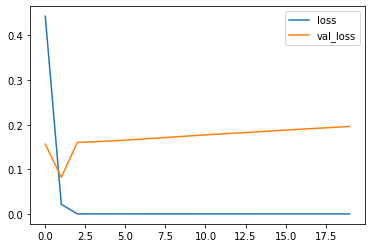

In [ ]:
metrics = pd.DataFrame(model_hist_3.history)
metrics[['loss', 'val_loss']].plot()

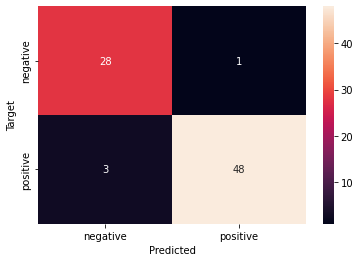

In [ ]:
p_pred = model.predict(X_test)
p_pred = p_pred.flatten()

# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)

cm_gru = confusion_matrix(y_test, y_pred)
def plot_cm(cm):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sns.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

plot_cm(cm_gru)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        29
           1       0.98      0.94      0.96        51

    accuracy                           0.95        80
   macro avg       0.94      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



Insight ;         
1. Tidak berbeda dari RNN dan LSTM, GRU mempunya akurasi yang sama yaitu 95% 
2. pembelajaran pada sentiment jg mirip dengan LSTM
3. Namun jika dibandingkan berdsasrkan grafik loss nya, RNN biasa lebih mempunyai grafik yang bagus dibandingkan LSTM dan GRU

---
# Model Improvement



In [ ]:
model = Sequential()
model.add(text_vectorization)
model.add(embedding)
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.tf', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model_hist_4 = model.fit(train_dataset, validation_data = (val_dataset), 
                         epochs = 100,
                         callbacks=[es, mc]
                         )

Epoch 1/100
19/23 [=======================>......] - ETA: 0s - loss: 0.6623 - accuracy: 0.8701
Epoch 1: val_accuracy improved from -inf to 0.96639, saving model to best_model.tf
INFO:tensorflow:Assets written to: best_model.tf/assets
23/23 [==============================] - 10s 398ms/step - loss: 0.6327 - accuracy: 0.8889 - val_loss: 0.4441 - val_accuracy: 0.9664
Epoch 2/100
21/23 [==========================>...] - ETA: 0s - loss: 0.3177 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.96639
23/23 [==============================] - 0s 12ms/step - loss: 0.3124 - accuracy: 1.0000 - val_loss: 0.2617 - val_accuracy: 0.9664
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.96639
23/23 [==============================] - 0s 11ms/step - loss: 0.1870 - accuracy: 1.0000 - val_loss: 0.1990 - val_accuracy: 0.9664
Epoch 4/100
18/23 [======================>.......] - ETA: 0s - loss: 0.1444 - accu

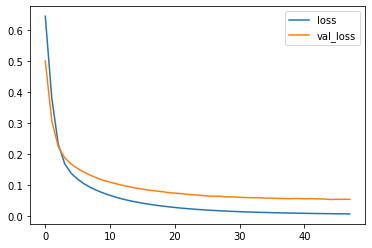

In [ ]:
metrics = pd.DataFrame(model_hist_4.history)
metrics[['loss', 'val_loss']].plot()

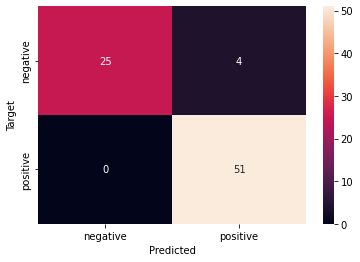

In [ ]:
p_pred = model.predict(X_test)
p_pred = p_pred.flatten()

# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)

cm_best = confusion_matrix(y_test, y_pred)
def plot_cm(cm):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sns.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

plot_cm(cm_best)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93        29
           1       0.93      1.00      0.96        51

    accuracy                           0.95        80
   macro avg       0.96      0.93      0.94        80
weighted avg       0.95      0.95      0.95        80



Insight ;           
1. untuk model improvement tidak terlalu terdapat perbedaan dari model yang pertama, hal ini mungkin dikarenakan karena dataset yang terlampu sedikit sehingga model tidak dapat mempelajari dengan maksimal
2. karena tidak terdapat fitting, utk improve hanya menambahkan weight initializer dan kernel regulazer menggunakan l2

---
# Model Inference

In [ ]:
new_tweet = ["I miss your tan skin, your sweet smile"]
p_pred = model.predict(new_tweet)
p_pred = p_pred.flatten()

# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)
y_pred


array([1])

In [ ]:
new_tweet = ["Who am I? Someone that's afraid to let go, uh",
              "You decide, if you're ever gonna let me know, yeah",
              "Suicide, if you ever try to let go, uh",
              "I'm sad I know, yeah, I'm sad I know, yeah"]
              
p_pred = model.predict(new_tweet)
p_pred = p_pred.flatten()

# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)
y_pred

array([1, 1, 0, 1])

Insight :     
Dari Model Inference dapat dilihat bahwa, terdapat ketidaksesuaian ketika tweet yang sebenarnya secara logika sedih tapi bernilai 1 atau positif,
alasanya dari data sentiment negatif yang tidak terlalu besar, dan dataset yang tidak terlalu banyak

---
# Kesimpulan

1. Pembuatan model ditujukan untuk mengetahui sentiment analysis terdapat data twitter
2. Makna dari kata, bisa dijadikan bahan utk menentukan apakah benar twet tersebut bermakna positf atau bukan, bila perlu dibandikan dengan skore polarity menggunakan library yang sudah ada
3. Hasil dari model jika dilihat dari akurasinya sudah cukup baik, namun kalau menggunakan data baru atau tweet baru kadang hasilnya tidak sesuai, ini dapat dikarenakan dasar kata yang hanya berjumlah 5 tiap sentiment, sehingga dimodel setelah ini dapat ditambahkan makna kata lain, atau bisa menggunakan emoji
